In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
shiba_folder = "/content/drive/MyDrive/Jenis_Anjing/Shiba_Inu"
husky_folder = "/content/drive/MyDrive/Jenis_Anjing/Siberian_Husky"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def ambil_data(folder_path):
    data = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        data.append(img_path)
    return data
def load_images(image_paths, target_size=(64, 64)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None or img.size == 0:
            continue
        img = cv2.resize(img, target_size)
        images.append(img)
    return np.array(images)
def normalize_images(images):
    return (images.astype(np.float32) - 127.5) / 127.5
def preprocess_images(image_paths, target_size=(64, 64)):
    images = load_images(image_paths, target_size)
    images = normalize_images(images)
    return images

In [ ]:
shiba_data = ambil_data(shiba_folder)
husky_data = ambil_data(husky_folder)
shiba = preprocess_images(shiba_data)
husky = preprocess_images(husky_data)
print(shiba.shape)
print(husky.shape)

(23, 64, 64, 3)
(23, 64, 64, 3)


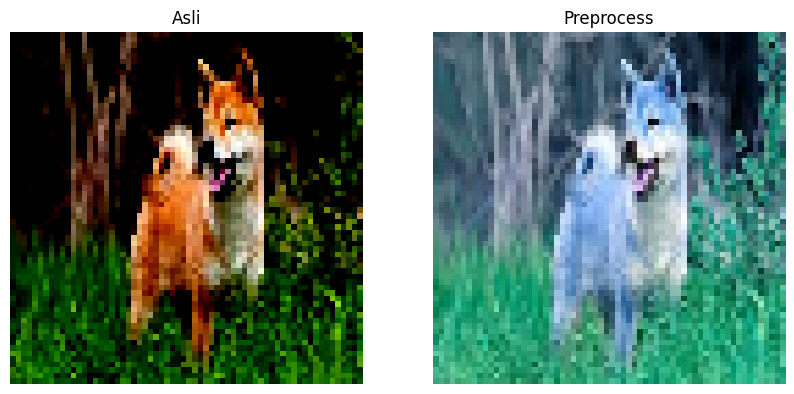

In [ ]:
def display_images(original_img, preprocess_img):

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Asli")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(preprocess_img)
    plt.title("Preprocess")
    plt.axis('off')
    plt.show()

display_images(shiba[0], (shiba[0] + 1) / 2)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, np.prod(img_shape)),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(np.prod(img_shape), 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [ ]:
latent_dim = 100
img_shape = (3, 64, 64)
generator = Generator(latent_dim, img_shape)
discriminator = Discriminator(img_shape)

In [ ]:
adversarial_loss = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
epochs = 50
batch_size = 64
half_batch = batch_size // 2

discriminator_losses = []
generator_losses = []

for epoch in range(epochs):
    for i in range(0, len(shiba), batch_size):
        real_batch_size = min(batch_size, len(shiba) - i)
        real_images = torch.tensor(shiba[i:i + real_batch_size])
        real_labels = torch.full((real_batch_size, 1), 1.0)
        noise = torch.randn(real_batch_size, latent_dim)
        generated_images = generator(noise)
        optimizer_discriminator.zero_grad()
        output_real = discriminator(real_images)
        loss_real = adversarial_loss(output_real, real_labels)
        loss_real.backward()
        output_fake = discriminator(generated_images.detach())
        fake_labels = torch.full((real_batch_size, 1), 0.0)
        loss_fake = adversarial_loss(output_fake, fake_labels)
        loss_fake.backward()
        optimizer_discriminator.step()
        optimizer_generator.zero_grad()
        output_generated = discriminator(generated_images)
        loss_generator = adversarial_loss(output_generated, real_labels)
        loss_generator.backward()
        optimizer_generator.step()
    discriminator_losses.append(loss_real.item() + loss_fake.item())
    generator_losses.append(loss_generator.item())

    print(f"Epoch [{epoch}/{epochs}] \t Discriminator Loss: {loss_real + loss_fake} \t Generator Loss: {loss_generator}")

Epoch [0/50] 	 Discriminator Loss: 1.3936996459960938 	 Generator Loss: 0.696492075920105
Epoch [1/50] 	 Discriminator Loss: 1.1911554336547852 	 Generator Loss: 0.7131767272949219
Epoch [2/50] 	 Discriminator Loss: 1.0100065469741821 	 Generator Loss: 0.7146860957145691
Epoch [3/50] 	 Discriminator Loss: 0.8918468952178955 	 Generator Loss: 0.7334085702896118
Epoch [4/50] 	 Discriminator Loss: 0.8197973370552063 	 Generator Loss: 0.7578084468841553
Epoch [5/50] 	 Discriminator Loss: 0.7557073831558228 	 Generator Loss: 0.7775651812553406
Epoch [6/50] 	 Discriminator Loss: 0.7179613709449768 	 Generator Loss: 0.809535562992096
Epoch [7/50] 	 Discriminator Loss: 0.6989620327949524 	 Generator Loss: 0.840885579586029
Epoch [8/50] 	 Discriminator Loss: 0.6494098901748657 	 Generator Loss: 0.8847700953483582
Epoch [9/50] 	 Discriminator Loss: 0.5998748540878296 	 Generator Loss: 0.9320122003555298
Epoch [10/50] 	 Discriminator Loss: 0.5816722512245178 	 Generator Loss: 0.9806584715843201
E

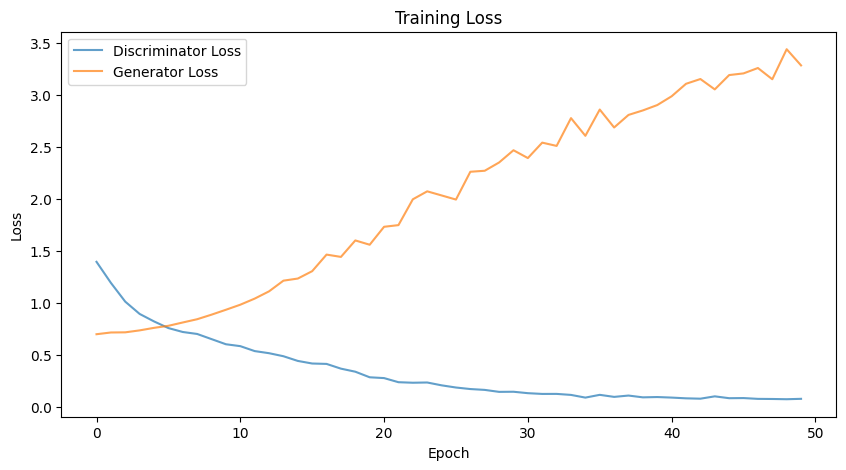

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(discriminator_losses, label="Discriminator Loss", alpha=0.7)
plt.plot(generator_losses, label="Generator Loss", alpha=0.7)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

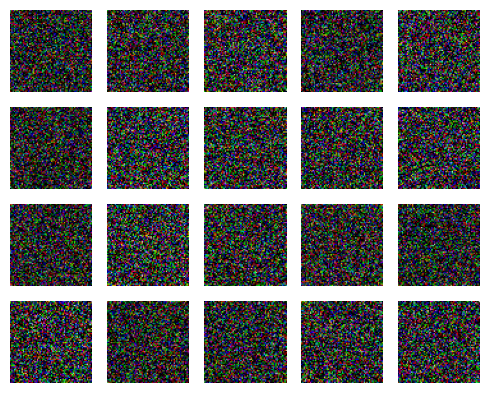

In [ ]:
def generate_and_display_images(generator, latent_dim, num_images=25, figsize=(5, 5)):
    noise = torch.randn(num_images, latent_dim)
    generated_images = generator(noise).detach().cpu()

    plt.figure(figsize=figsize)
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        plt.imshow(generated_images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.tight_layout()
    plt.show()

generate_and_display_images(generator, latent_dim, num_images=20)